# Commodity Trading
*Xiaoqiong(Joan) Zhang*

**This commodity curve strategy is constructed by trading WTI futures.**  

The commodity curve strategy takes a long position of an optimally-chosen contract and a short position of another contract at any time in order to capture the commodity's term struture premium.

Here are the steps for portfolio construction and rebalancing:
* Step 1: At each month-end date, we consider contracts on tenors from T2 to T12. (T1 contract would not be considered since it has less than 1 month to expiration)
* Step 2A: For each tenor contract, calculate the expected rolling return if holding the contract for one month based on the current term structure.  (Let's assume the expiration dates of two adjacent contracts are always exactly one-month away).
* Step 2B: Among the 11 contracts (from T2 to T12), build a portfolio with one long position in the contract with the highest expected rolling return, and one short position in the contract with the lowest expected rolling return.
* Step 3: Hold the portfolio till the next month-end and rebalance the portfolio.

Here are the back-test for the strategy from 1/31/2000 to 1/31/2019, calculating the strategy's daily returns, and deliver the following results:
1. Assume the initial investment is $1 in the strategy from day 1, i.e., 1/31/2000, plot the value of our investment over time.
2. Calculate the strategy's calendar year returns, i.e., cumulative returns in each year from 2000 to 2019.
3. Calculate the annualized return, annualized risk, and Sharpe ratio (let's assume risk-free rate of 0) of the strategy.
4. Identify the maximum drawdown period for this strategy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Data Process**
1. Input Futures data from excel
2. Rearrange data to get the dataframe including price information at each month-end date.

In [2]:
# Input data
data = pd.read_excel('WTI_OilCurve.XLSX','WTI_FuturesCurve',skiprows=1,parse_dates=[0],index_col=[0])

# Extract daily price information
price = pd.DataFrame(data['PX LAST'],index=data.index)
price = price.rename(columns = {'PX LAST':'T1'})

for i in range(1,12):
    str1 = 'PX LAST.' + str(i)
    str2 = 'T' + str(i+1)
    price[str2] = data[str1]
    
# Rearrange Data to get the price at each month-end date
price = price.resample('M').last()
price = price.to_period('M')

price.head()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12
1,,,,,,,,,,,,
2000-01,27.64,26.72,25.97,25.32,24.71,24.17,23.71,23.27,22.87,22.49,22.14,21.81
2000-02,30.43,28.85,27.68,26.74,26.00,25.35,24.79,24.32,23.88,23.44,23.04,22.65
2000-03,26.90,26.38,26.04,25.76,25.48,25.19,24.90,24.60,24.28,23.97,23.68,23.39
2000-04,25.74,25.48,25.15,24.86,24.59,24.32,24.07,23.82,23.57,23.32,23.08,22.85
2000-05,29.01,28.42,27.89,27.40,26.92,26.47,26.06,25.69,25.32,24.95,24.58,24.21


**Rolling Return**

Assume the expiration dates of two adjacent contracts are always exactly one-month away.

$$RollingReturn_{t+1}^i = \frac{F_{t+1}^i}{F_t^i} - 1$$ where $i = {T2, T3, ...,T12}$

In [3]:
rolling_ret = pd.DataFrame(index=price.index)
for i in range(1,12):
    str1 = 'T' + str(i)
    str2 = 'T' + str(i+1)
    rolling_ret[str2] = price[str1]/price[str2].shift() - 1

rolling_ret.head()

,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12
1,,,,,,,,,,,
2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02,0.138847,0.110897,0.093207,0.082153,0.075714,0.069169,0.065320,0.063402,0.061805,0.058717,0.056396
2000-03,-0.067591,-0.046965,-0.026178,-0.009231,0.005128,0.016136,0.023849,0.030151,0.035836,0.040365,0.045475
2000-04,-0.024261,-0.021505,-0.023680,-0.024333,-0.023819,-0.023293,-0.021545,-0.018946,-0.016688,-0.015203,-0.013254
2000-05,0.138540,0.130020,0.121883,0.114274,0.106908,0.099709,0.094039,0.089945,0.085763,0.081023,0.075711


**Portfolio Construction**

Build a portfolio with one long position in the contract with the highest expected rolling return, and one short position in the contract with the lowest expected rolling return.

In [4]:
# Rank
rolling_ret['Max'] = np.nan
rolling_ret['Min'] = np.nan
long_contract = []
short_contract = []

for i in rolling_ret.index:
    long_contract.append(rolling_ret.loc[i].idxmax())
    short_contract.append(rolling_ret.loc[i].idxmin())
    
    rolling_ret['Max'] = rolling_ret.max(axis=1)
    rolling_ret['Min'] =rolling_ret.min(axis=1)
    
rolling_ret['Long'] = long_contract
rolling_ret['Short'] = short_contract

In [5]:
rolling_ret[['Max','Long','Min','Short']].head()

,Max,Long,Min,Short
1,,,,
2000-01,NaN,NaN,NaN,NaN
2000-02,0.138847,T2,0.056396,T12
2000-03,0.045475,T12,-0.067591,T2
2000-04,-0.013254,T12,-0.024333,T5
2000-05,0.138540,T2,0.075711,T12


In [6]:
# Portfolio Return
rolling_ret = rolling_ret[1:]
port_ret = []
for i in rolling_ret.index[:-1]:
    buy_c = rolling_ret['Long'].loc[i]
    buy_ret = rolling_ret[buy_c].shift(-1).loc[i+1]
    
    sell_c = rolling_ret['Short'].loc[i]
    sell_ret = rolling_ret[sell_c].shift(-1).loc[i+1]
    
    port_ret.append(buy_ret - sell_ret)

port_ret = pd.DataFrame(port_ret[:-1], index=rolling_ret.index[1:-1],columns=['return'])

In [7]:
port_ret.head()

,return
1,
2000-03,-0.011007
2000-04,-0.062829
2000-05,-0.012774
2000-06,-0.101462
2000-07,0.102986


**Performance Analysis**

In [8]:
def Maximum_DD(data):
    Roll_Max = data.cummax()
    Daily_DD = -(data/Roll_Max - 1.0)
    MaxDD = Daily_DD.max()
    Daily_MaxDD = Daily_DD.cummax()
    
    d2 = Daily_DD.idxmax()
    d1 = Roll_Max.loc[:d2].idxmax()
    d1_value = data.loc[d1]
    d2_value = data.loc[d2]
    return MaxDD,Daily_MaxDD,Daily_DD,d2,d1,d1_value,d2_value

def summary_table(port_ret_data,alpha=0.05):
    
    y_ret = (port_ret_data+1).resample('Y').prod() - 1
    value = (port_ret_data+1).cumprod()
    
    x = y_ret.describe()
    x.drop(['count','25%','50%','75%','mean','std'], inplace=True)
    x.loc['Ann_Ret'] = ((y_ret+1).prod())**(1/len(y_ret)) - 1
    x.loc['Ann_Vol'] = port_ret_data.std() * np.sqrt(12)
    x.loc['Sharpe Ratio'] = x.loc['Ann_Ret']/x.loc['Ann_Vol']
    x.loc['VaR'] = port_ret_data.quantile(alpha)
    x.loc['CVaR'] = port_ret_data[port_ret_data<=x.loc['VaR']].mean()
    x.loc['MMD'] = Maximum_DD(value)[0]
    
    summary = pd.concat([y_ret,x])
    
    return summary, value

In [9]:
summary,value = summary_table(port_ret['return'])

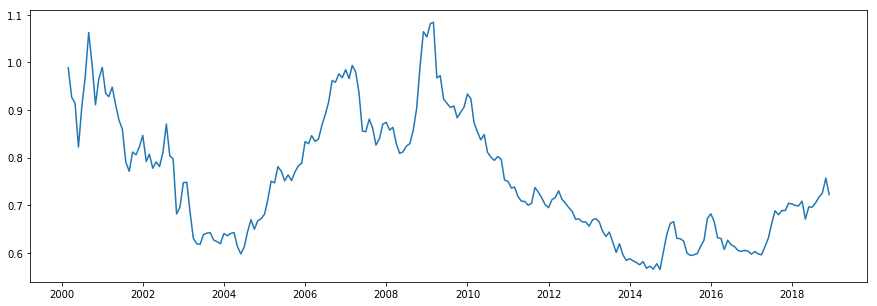

In [10]:
# Plot the value of our investment over time.
plt.figure(figsize=(15,5))
plt.plot(value.to_timestamp())

In [11]:
# Calculate Calendar year returns
# Calculate annualized return and annualized volatility, Sharpe ratio, VaR, CVaR, MMD
pd.DataFrame(summary)

,return
2000,-0.034777
2001,-0.147697
2002,-0.154624
2003,-0.109370
2004,0.084841
2005,0.173062
2006,0.227814
2007,-0.100834
2008,0.223408
2009,-0.149276


In [12]:
# Identify the maximum drawdown period for this strategy.
MaxDD,Daily_MaxDD,Daily_DD,d2,d1,d1_value,d2_value = Maximum_DD(value)
print('The highest value happened at the end of',d1)
print('The highest maximum drawdown happened at the end of',d2)
print('the maximum drawdown period is from %s to %s.' % (d1,d2))

The highest value happened at the end of 2009-03
The highest maximum drawdown happened at the end of 2014-10
the maximum drawdown period is from 2009-03 to 2014-10.


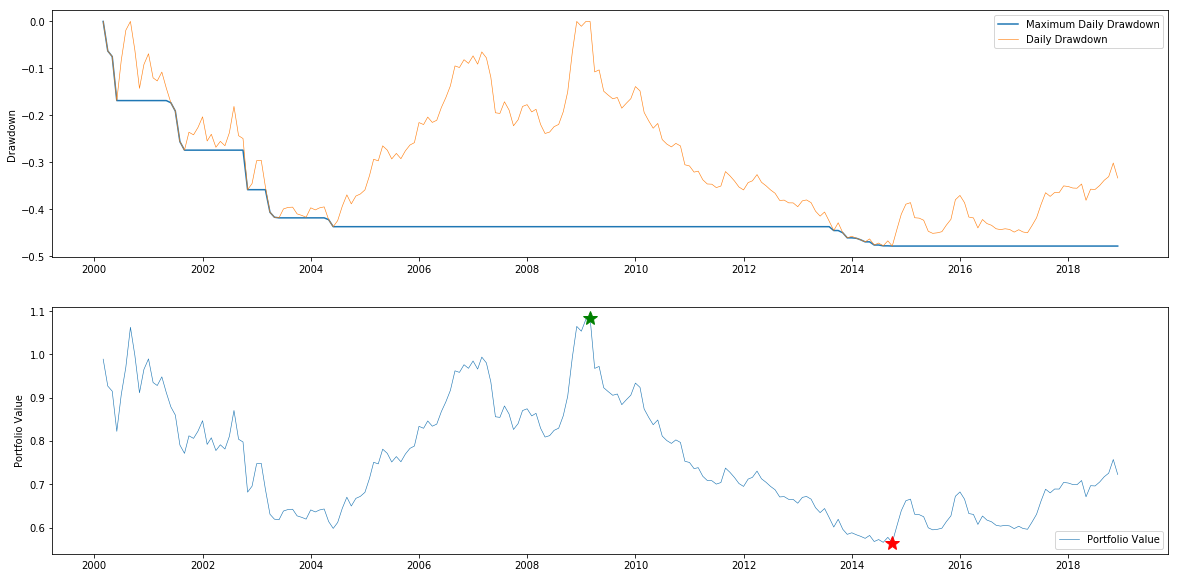

In [13]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(-Daily_MaxDD.to_timestamp(),label='Maximum Daily Drawdown',linewidth=1.5)
ax1.plot(-Daily_DD.to_timestamp(),label='Daily Drawdown',linewidth=0.6)
ax1.set_ylabel('Drawdown')
ax1.legend()

ax2.plot(value.to_timestamp(),label='Portfolio Value',linewidth=0.6)
ax2.plot(d1.to_timestamp(),d1_value,marker="*",c='g',ms=15)
ax2.plot(d2.to_timestamp(),d2_value,marker="*",c='r',ms=15)
ax2.set_ylabel('Portfolio Value')
ax2.legend(loc='lower right')

plt.show()